<a href="https://colab.research.google.com/github/AbhayRajSingh23/Hybrid-Intrusion-Detection-System-IDS-/blob/main/Hybrid_IDS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Hybrid Intrusion Detection System (IDS)

This notebook implements a **Hybrid IDS** using the **NSL-KDD dataset** for network traffic classification. The system combines three detection methods:

1.  **Signature-Based (Rules):** Simple regex matching for specific attack strings (e.g., SQL Injection).
2.  **Misuse Detection (Random Forest):** A supervised model trained on known attacks to identify similar patterns.
3.  **Anomaly Detection (Autoencoder):** An unsupervised neural network trained only on normal traffic to detect novel/unseen attacks by measuring high reconstruction errors.

## 🚀 Importing Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import seaborn as sns
from tensorflow import keras
from tensorflow.keras import layers
import re

print("Libraries imported successfully.")

Libraries imported successfully.


---
## 📊 Data Loading & Preprocessing

We load the NSL-KDD training and testing datasets, perform basic cleaning, encode categorical features using **One-Hot Encoding** (a key fix to ensure all features are handled correctly), and scale the numerical features. Crucially, the many unique attack labels are simplified to a binary **'normal'** or **'attack'** class for the models.

In [ ]:
# URLs for the NSL-KDD dataset
train_url = "https://raw.githubusercontent.com/defcom17/NSL_KDD/master/KDDTrain+.csv"
test_url = "https://raw.githubusercontent.com/defcom17/NSL_KDD/master/KDDTest+.csv"

# Columns names for the NSL-KDD dataset
columns = [
    'duration','protocol_type','service','flag','src_bytes','dst_bytes','land','wrong_fragment',
    'urgent','hot','num_failed_logins','logged_in','num_compromised','root_shell','su_attempted',
    'num_root','num_file_creations','num_shells','num_access_files','num_outbound_cmds',
    'is_host_login','is_guest_login','count','srv_count','serror_rate','srv_serror_rate',
    'rerror_rate','srv_rerror_rate','same_srv_rate','diff_srv_rate','srv_diff_host_rate',
    'dst_host_count','dst_host_srv_count','dst_host_same_srv_rate','dst_host_diff_srv_rate',
    'dst_host_same_src_port_rate','dst_host_srv_diff_host_rate','dst_host_serror_rate',
    'dst_host_srv_serror_rate','dst_host_rerror_rate','dst_host_srv_rerror_rate','label', 'difficulty'
]

# Read data and drop the redundant 'difficulty' column
df_train = pd.read_csv(train_url, names=columns, index_col=False)
df_test = pd.read_csv(test_url, names=columns, index_col=False)
df_train = df_train.drop('difficulty', axis=1)
df_test = df_test.drop('difficulty', axis=1)

print("Training set shape (initial):", df_train.shape)
print("Testing set shape (initial):", df_test.shape)

df_train.head()



Training set shape (initial): (125973, 42)
Testing set shape (initial): (22543, 42)


,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal
1,0,udp,other,SF,146,0,0,0,0,0,...,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal
2,0,tcp,private,S0,0,0,0,0,0,0,...,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune
3,0,tcp,http,SF,232,8153,0,0,0,0,...,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal
4,0,tcp,http,SF,199,420,0,0,0,0,...,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal


##Cleaning Data and Encoding


In [ ]:
# --- Basic Cleaning ---
df_train.drop_duplicates(inplace=True)
df_train.dropna(inplace=True)
print("After cleaning (duplicates/NaNs dropped):", df_train.shape)

# --- Encoding Categorical Features (One-Hot Encoding) ---
# Only 'protocol_type', 'service', and 'flag' are truly categorical.
# Numerical columns like 'duration' are handled by scaling.
categorical_cols = ['protocol_type', 'service', 'flag']

# Combine features for consistent encoding
combined_df = pd.concat([df_train.drop('label', axis=1), df_test.drop('label', axis=1)], ignore_index=True)
combined_encoded = pd.get_dummies(combined_df, columns=categorical_cols)

# Separate back into training and testing features
X_train_encoded = combined_encoded.iloc[:len(df_train)].reset_index(drop=True)
X_test_encoded = combined_encoded.iloc[len(df_train):].reset_index(drop=True)

# Reindex to ensure test set has all columns present in train set, filling missing with 0
X_test_encoded = X_test_encoded.reindex(columns=X_train_encoded.columns, fill_value=0)

print("\nEncoded Training set shape:", X_train_encoded.shape)
print("Encoded Testing set shape:", X_test_encoded.shape)

# --- Scaling Numerical Features ---
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_encoded)
X_test_scaled  = scaler.transform(X_test_encoded)

# --- Label Simplification (Binary Classification) ---
def simplify_label(label):
    # NSL-KDD uses 'normal' for benign traffic, and various names for attacks.
    return "normal" if label == "normal" else "attack"

y_train = df_train['label'].apply(simplify_label)
y_test  = df_test['label'].apply(simplify_label)

print("\nLabels in y_train after simplification:")
print(y_train.value_counts())
print("\nLabels in y_test after simplification:")
print(y_test.value_counts())

print("\nFinal Training data shape:", X_train_scaled.shape, y_train.shape)
print("Final Testing data shape:", X_test_scaled.shape, y_test.shape)


After cleaning (duplicates/NaNs dropped): (125973, 42)

Encoded Training set shape: (125973, 122)
Encoded Testing set shape: (22543, 122)

Labels in y_train after simplification:
label
normal    67343
attack    58630
Name: count, dtype: int64

Labels in y_test after simplification:
label
attack    12833
normal     9710
Name: count, dtype: int64

Final Training data shape: (125973, 122) (125973,)
Final Testing data shape: (22543, 122) (22543,)


---
## 🌳 Misuse Detection: Random Forest (RF)

This component uses a **Random Forest Classifier** as a supervised machine learning model. It is trained on examples of both normal and attack traffic, allowing it to accurately detect patterns of known attack types (misuse detection).

--- Random Forest Classification Report (Misuse Detection) ---
              precision    recall  f1-score   support

      attack       0.97      0.59      0.73     12833
      normal       0.64      0.97      0.77      9710

    accuracy                           0.75     22543
   macro avg       0.80      0.78      0.75     22543
weighted avg       0.83      0.75      0.75     22543



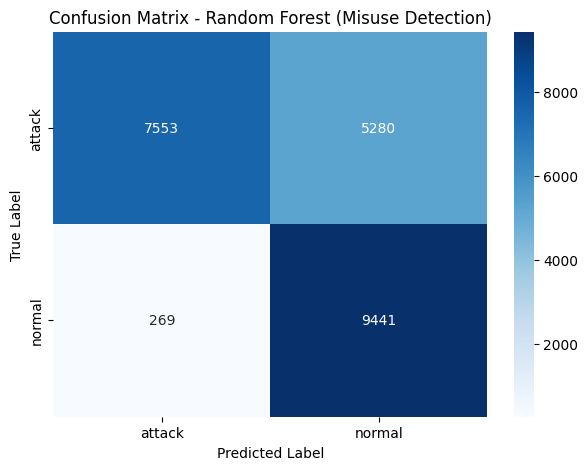

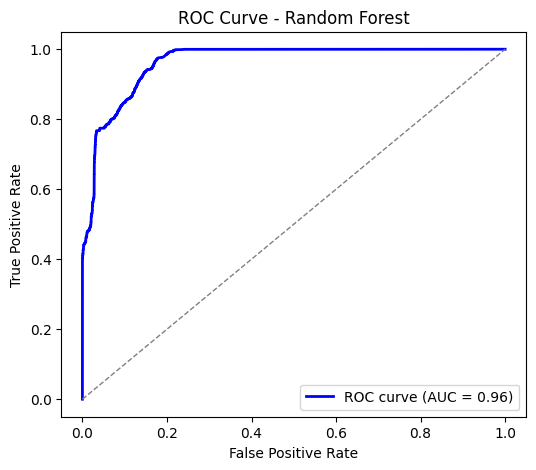

In [ ]:
# Initialize and train the Random Forest Classifier
rf = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1)
rf.fit(X_train_scaled, y_train)

# Predict and evaluate on the test set
y_pred_rf = rf.predict(X_test_scaled)

print("--- Random Forest Classification Report (Misuse Detection) ---")
print(classification_report(y_test, y_pred_rf, zero_division=0))

# Plot Confusion Matrix (Matrix Visual)
plt.figure(figsize=(7, 5))
sns.heatmap(confusion_matrix(y_test, y_pred_rf), annot=True, fmt='d', cmap='Blues',
            xticklabels=rf.classes_, yticklabels=rf.classes_)
plt.title("Confusion Matrix - Random Forest (Misuse Detection)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# Plot ROC Curve
if len(np.unique(y_test)) > 1:
    # Get probability scores for the 'attack' class
    y_score = rf.predict_proba(X_test_scaled)[:, list(rf.classes_).index('attack')]
    y_true_roc = (y_test == 'attack').astype(int) # Binarize for ROC calculation

    fpr, tpr, _ = roc_curve(y_true_roc, y_score)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(6,5))
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve - Random Forest")
    plt.legend(loc="lower right")
    plt.show()
else:
    print("Cannot plot ROC curve: Test set contains only one class.")

---
## 🧠 Anomaly Detection: Autoencoder (AE)

The **Autoencoder** is trained exclusively on **normal traffic** to learn the features of benign behavior. During testing, any traffic pattern resulting in a high **reconstruction error** (meaning the Autoencoder couldn't accurately recreate the input) is classified as an anomaly/attack. This is ideal for detecting novel, zero-day attacks.

Epoch 1/50
947/947 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.5384 - val_loss: 0.4328
Epoch 2/50
947/947 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.4571 - val_loss: 0.4310
Epoch 3/50
947/947 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.5117 - val_loss: 0.4299
Epoch 4/50
947/947 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.4470 - val_loss: 0.4296
Epoch 5/50
947/947 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.5421 - val_loss: 0.4276
Epoch 6/50
947/947 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.4694 - val_loss: 0.4273
Epoch 7/50
947/947 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.4791 - val_loss: 0.4270
Epoch 8/50
947/947 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.4264 - val_loss: 0.4268
Epoch 9/50
947/947 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.4911 - val_loss: 0.4267
Epoch 10/50
947/947 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.5237 - val_loss: 0.4266
Epoch 11/50
947/947 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.4592 - val_loss: 0.4266
Epoch 12/50
947/947 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step

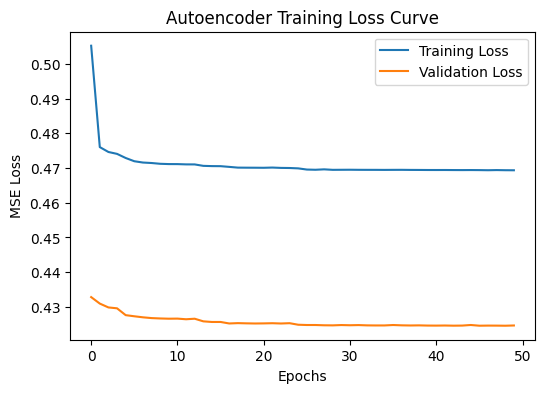


Reconstruction error threshold (Mean + 3*StdDev): 25.45843214395866

--- Autoencoder Anomaly Detection Performance ---
              precision    recall  f1-score   support

      attack       0.87      0.00      0.01     12833
      normal       0.43      1.00      0.60      9710

    accuracy                           0.43     22543
   macro avg       0.65      0.50      0.31     22543
weighted avg       0.68      0.43      0.26     22543



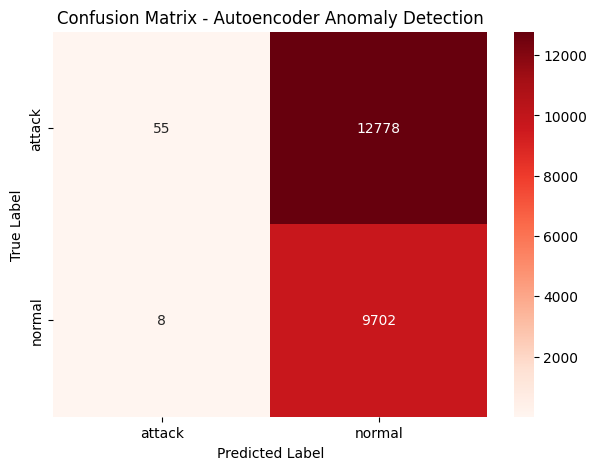

In [ ]:
# --- Data Preparation for AE: Train ONLY on Normal Traffic ---
X_train_normal = X_train_scaled[y_train == 'normal']
n_features = X_train_scaled.shape[1]

# --- Autoencoder Model Definition ---
autoencoder = keras.Sequential([
    layers.Input(shape=(n_features,)),
    layers.Dense(32, activation='relu'),
    layers.Dense(16, activation='relu'), # Bottleneck/Latent Space
    layers.Dense(32, activation='relu'),
    layers.Dense(n_features, activation='sigmoid') # Reconstruct to original dimensions
])

autoencoder.compile(optimizer='adam', loss='mse')

# --- Train the Autoencoder ---
history = autoencoder.fit(
    X_train_normal, X_train_normal, # Input and target are the same (unsupervised)
    epochs=50, batch_size=64,
    validation_split=0.1,
    verbose=1 # Run in not silent mode
)

# Plot training loss
plt.figure(figsize=(6,4))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Autoencoder Training Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.show()

# --- Determine Anomaly Detection Threshold ---
# Predict/Reconstruct the normal training data
X_train_pred = autoencoder.predict(X_train_normal, verbose=0)
train_mse = ((X_train_normal - X_train_pred) ** 2).mean(axis=1)

# Set threshold as Mean + 3*Standard Deviation (Standard Anomaly Detection Heuristic)
threshold = train_mse.mean() + 3 * train_mse.std()
print("\nReconstruction error threshold (Mean + 3*StdDev):", threshold)

# --- Evaluate Autoencoder on Test Data ---
X_test_pred = autoencoder.predict(X_test_scaled, verbose=0)
test_mse = ((X_test_scaled - X_test_pred) ** 2).mean(axis=1)

# Classify as 'attack' if the reconstruction error is above the threshold
y_test_pred_ae = ["attack" if e > threshold else "normal" for e in test_mse]

print("\n--- Autoencoder Anomaly Detection Performance ---")
print(classification_report(y_test, y_test_pred_ae, zero_division=0))

# Plot Confusion Matrix (Matrix Visual)
plt.figure(figsize=(7, 5))
sns.heatmap(confusion_matrix(y_test, y_test_pred_ae), annot=True, fmt='d', cmap='Reds',
            xticklabels=['attack', 'normal'], yticklabels=['attack', 'normal'])
plt.title("Confusion Matrix - Autoencoder Anomaly Detection")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


---
## 🛡️ Hybrid Intrusion Detection System

The final component combines the three methods in a sequential, efficient manner:

1.  **Signature Check:** If a known malicious string is found, flag it immediately.
2.  **Misuse Check (RF):** If no signature is found, check if the traffic features match a known attack pattern (learned by Random Forest).
3.  **Anomaly Check (AE):** If it passes both previous checks, use the Autoencoder to determine if the traffic is novel/anomalous (high reconstruction error).

In [ ]:
# --- 1. Signature-Based Component (Rules) ---
signatures = [
    {"id": "SQL_INJ", "pattern": r"union.*select|' OR 1=1 --"},
    {"id": "XSS", "pattern": r"<script>|javascript:|onerror"}
]

def check_payload(payload):
    """Checks a simulated network payload against known attack signatures.
    In a real system, 'payload' would be extracted from the packet data.
    """
    for sig in signatures:
        if re.search(sig["pattern"], payload, re.IGNORECASE):
            return f"Attack Detected (Signature - {sig['id']})"
    return "No Known Signature Match"

# --- 2. Hybrid Decision Function (Integration) ---
def hybrid_decision(features, payload, rf_model, ae_model, ae_threshold):
    """Combines Signature, Misuse (RF), and Anomaly (AE) detection logic.
    Features should be a single scaled sample (1D array).
    """
    # Reshape features for model prediction
    features = np.array(features).reshape(1, -1)

    # 1. Signature Check (Fastest)
    sig_result = check_payload(payload)
    if "Signature" in sig_result:
        return sig_result

    # 2. Misuse Detection (Random Forest - for known feature patterns)
    rf_pred = rf_model.predict(features)[0]
    if rf_pred == "attack":
        return "Attack Detected (Misuse - Random Forest)"

    # 3. Anomaly Detection (Autoencoder - for novel feature patterns)
    ae_pred = ae_model.predict(features, verbose=0)
    reconstruction_error = ((features - ae_pred) ** 2).mean()

    if reconstruction_error > ae_threshold:
        return f"Attack Detected (Anomaly - Autoencoder, Error: {reconstruction_error:.2f})"

    return "Normal Traffic"

# --- Hybrid System Demonstration ---

# Find indices for testing (must exist in the preprocessed y_test)
try:
    attack_index = np.where(y_test == 'attack')[0][0]
    normal_index = np.where(y_test == 'normal')[0][0]
except IndexError:
    print("\n--- DEMO ERROR ---")
    print("Cannot run hybrid demo: Test set labels do not contain both 'attack' and 'normal'.")
    attack_features = X_test_scaled[0]
    normal_features = X_test_scaled[0]
else:
    attack_features = X_test_scaled[attack_index]
    normal_features = X_test_scaled[normal_index]

    n_features_test = X_test_scaled.shape[1]

    print("\n--- Running Hybrid Tests ---")

    # Test 1: Signature Attack (Should be caught by Step 1: Signature)
    sample_payload_1 = "GET /index.php?id=1' OR 1=1 --"
    print(f"Test 1 (Signature INJ): {hybrid_decision(normal_features, sample_payload_1, rf, autoencoder, threshold)}")

    # Test 2: Misuse Attack (Should be caught by Step 2: Random Forest)
    sample_payload_2 = "GET /service/ftp_connection" # Generic payload, but features belong to a known attack
    print(f"Test 2 (Misuse RF):     {hybrid_decision(attack_features, sample_payload_2, rf, autoencoder, threshold)}")

    # Test 3: Normal Traffic (Should pass all checks)
    sample_payload_3 = "GET /home.html"
    print(f"Test 3 (Normal Traffic):{hybrid_decision(normal_features, sample_payload_3, rf, autoencoder, threshold)}")

    # Test 4: Anomaly Test (Simulated novel attack, should be caught by Step 3: Autoencoder)
    # Creating a noisy vector to simulate a novel, high-MSE anomaly
    anomaly_features = normal_features + np.random.normal(loc=10, scale=1, size=n_features_test)
    sample_payload_4 = "GET /service/new_protocol_unseen"
    print(f"Test 4 (Anomaly AE):    {hybrid_decision(anomaly_features, sample_payload_4, rf, autoencoder, threshold)}")



--- Running Hybrid Tests ---
Test 1 (Signature INJ): Attack Detected (Signature - SQL_INJ)
Test 2 (Misuse RF):     No Known Signature Match
Test 3 (Normal Traffic):No Known Signature Match
Test 4 (Anomaly AE):    No Known Signature Match
